## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
import sys
sys.path.append("search/")
import environment

import matplotlib.pyplot as plt

## Medium Environment - Training

Linear layer input size:  224
Linear layer input size:  224
Initial state:


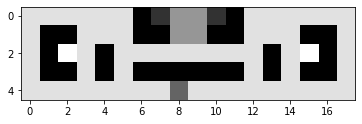

Shape:  (5, 18, 1)
Episode:  100 Average Score: -9.85 Winrate: 0.00%
Episode:  200 Average Score: -31.87 Winrate: 0.00%
Episode:  300 Average Score: -5.52 Winrate: 0.00%
Episode:  400 Average Score: -12.62 Winrate: 0.00%
Episode:  500 Average Score: -4.46 Winrate: 0.00%
Episode:  600 Average Score: 5.88 Winrate: 0.00%
Episode:  700 Average Score: -7.09 Winrate: 0.00%
Episode:  800 Average Score: -0.21 Winrate: 0.00%
Episode:  900 Average Score: 6.92 Winrate: 0.00%
Episode:  1000 Average Score: -10.11 Winrate: 0.00%
Episode:  1100 Average Score: -17.70 Winrate: 0.00%
Episode:  1200 Average Score: -21.22 Winrate: 0.00%
Episode:  1300 Average Score: -18.83 Winrate: 0.00%
Episode:  1400 Average Score: -28.83 Winrate: 0.00%
Episode:  1500 Average Score: -22.93 Winrate: 0.00%
Episode:  1600 Average Score: -18.22 Winrate: 0.00%
Episode:  1700 Average Score: -15.56 Winrate: 0.00%
Episode:  1800 Average Score: -11.45 Winrate: 0.00%
Episode:  1900 Average Score: -17.69 Winrate: 0.00%
Episode:  2

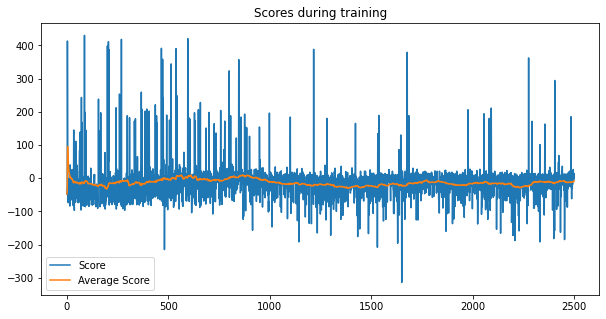

In [2]:
params = {
    "buffer_size": int(1e5),  # replay buffer size
    "batch_size": 128,        # minibatch size
    "gamma": 0.99,            # discount factor
    "tau": 1e-5,              # for soft update of target parameters
    "lr": 1e-5,               # learning rate
    "weight_decay": 0.0001,   # Adam parameter
    "update_every": 5         # how often to update the network
}

# layouts = smallClassic, mediumClassic, originalClassic
env = environment.Environment(params, layout="smallClassic")

eps_start = 1.0   # Starting exploration rate
eps_end = 0.05    # Minimun exploration rate (0.05 = 5%)
eps_decay=0.999
n_episodes = 2500
print_every = 100 # episodes

eps = eps_start
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    env.scores.append(env.game.state.getScore())
    env.scores_window.append(env.game.state.getScore())

    env.wins.append(env.game.state.isWin())
    env.wins_window.append(env.game.state.isWin())

    average_score = sum(env.scores_window)/float(len(env.scores_window))
    winrate = sum(env.wins_window)/float(len(env.wins_window)) * 100.0
    env.average_scores.append(average_score)

    if i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate))

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
line1, = plt.plot(env.scores)
line2, = plt.plot(env.average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()